In [7]:
import csv
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt  
from ipywidgets import interact, FloatSlider
from datetime import datetime

import os

In [55]:
# Préparation des dataframes des séries temporelles
Data_file = "data/Data/S1A_ASC-DSC_VV-VH_Paracou"

df_VH_ASC_TropiScat = pd.read_csv(f"{Data_file}/s1a_vh_ASC_047_TropiScat.csv")
df_VH_DSC_TropiScat =  pd.read_csv(f"{Data_file}/s1a_vh_DSC_039_TropiScat.csv")
df_VV_ASC_TropiScat =  pd.read_csv(f"{Data_file}/s1a_vv_ASC_047_TropiScat.csv")
df_VV_DSC_TropiScat =  pd.read_csv(f"{Data_file}/s1a_vv_DSC_039_TropiScat.csv")

dfs_TropiScat = {
    "VV_ASC": df_VV_ASC_TropiScat,
    "VH_ASC": df_VH_ASC_TropiScat,
    "VV_DSC": df_VV_DSC_TropiScat,
    "VH_DSC": df_VH_DSC_TropiScat,
}
df_VH_ASC_allROI =  pd.read_csv(f"{Data_file}/s1a_vh_ASC_047_allROI.csv")
df_VH_DSC_allROI =  pd.read_csv(f"{Data_file}/s1a_vh_DSC_039_allROI.csv")
df_VV_ASC_allROI =  pd.read_csv(f"{Data_file}/s1a_vv_ASC_047_allROI.csv")
df_VV_DSC_allROI =  pd.read_csv(f"{Data_file}/s1a_vv_DSC_039_allROI.csv")

dfs_allROI = {
    "VV_ASC": df_VV_ASC_allROI,
    "VH_ASC": df_VH_ASC_allROI,
    "VV_DSC": df_VV_DSC_allROI,
    "VH_DSC": df_VH_DSC_allROI,
}


value_TropiScat= {
    "VV_ASC": df_VV_ASC_TropiScat.select_dtypes(include='number').to_numpy(),
    "VH_ASC": df_VH_ASC_TropiScat.select_dtypes(include='number').to_numpy(),
    "VV_DSC": df_VV_DSC_TropiScat.select_dtypes(include='number').to_numpy(),
    "VH_DSC": df_VH_DSC_TropiScat.select_dtypes(include='number').to_numpy(),
}

value_allROI = {
    "VV_ASC": df_VV_ASC_allROI.select_dtypes(include='number').to_numpy(),
    "VH_ASC": df_VH_ASC_allROI.select_dtypes(include='number').to_numpy(),
    "VV_DSC": df_VV_DSC_allROI.select_dtypes(include='number').to_numpy(),
    "VH_DSC": df_VH_DSC_allROI.select_dtypes(include='number').to_numpy(),
}

date_TropiScat= {
    "VV_ASC": np.array(df_VV_ASC_TropiScat)[:,0],
    "VH_ASC": np.array(df_VH_ASC_TropiScat)[:,0],
    "VV_DSC": np.array(df_VV_DSC_TropiScat)[:,0],
    "VH_DSC": np.array(df_VH_DSC_TropiScat)[:,0],
}
date_allROI= {
    "VV_ASC": np.array(df_VV_ASC_allROI)[:,0],
    "VH_ASC": np.array(df_VH_ASC_allROI)[:,0],
    "VV_DSC": np.array(df_VV_DSC_allROI)[:,0],
    "VH_DSC": np.array(df_VH_DSC_allROI)[:,0],
}

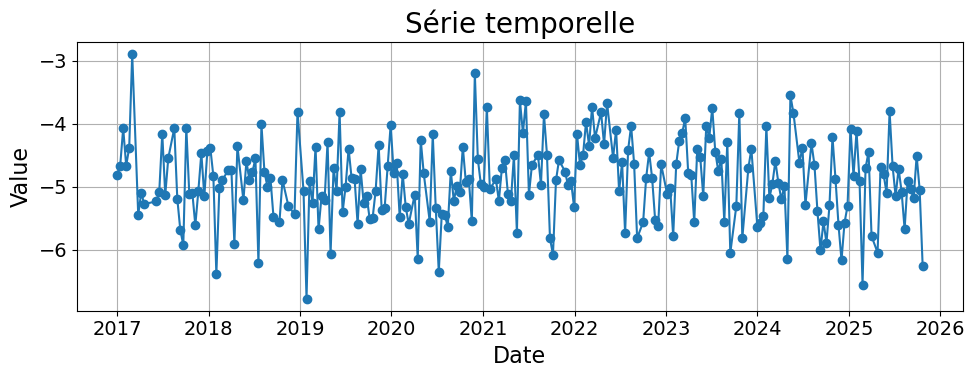

In [58]:

# La série temporelle
T=date_TropiScat['VV_ASC']
dates= [datetime.strptime(t, "%Y-%m-%d") for t in T]
days = np.array([(d - dates[0]).days for d in dates])
intervals=np.diff(days)
fs=1/np.mean(intervals)

values=value_TropiScat['VV_ASC']

plt.figure(figsize=(10,4))
plt.plot(dates, values, marker='o')
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Série temporelle")
plt.grid(True)

plt.tight_layout()
plt.show()  

In [62]:


def psd_welch_annee(df, nom, window_lengths=[730, 900, 1000], overlap_ratios=[0.30, 0.40, 0.50], n_peaks=2, outdir="figures_welch", prefix="PSD", show=True):
    df=df[nom]
    y = df[:,0]
    fs = 1/12  # Sentinel-1, un point/12 jours
    os.makedirs(outdir, exist_ok=True)
    # Boucle sur l'overlap et sur la wl
    for ol in overlap_ratios:
        plt.figure(figsize=(10, 6))
        print(f"\n===== Overlap Analysis = {ol*100:.0f}% =====")
        for wl in window_lengths:
            wl_samples = int(np.floor(wl / 12))  # window en nombre de samples
            nperseg = min(wl_samples, len(y))   # nb échantillons dans la fenêtre (taille de la fenêtre ou nombre d'échantillons restants si on est proche de la fin)
            noverlap = int(nperseg * ol)    # overlap en nombre de samples

            freqs, psd = welch(y, fs=fs, nperseg=nperseg, noverlap=noverlap)    # fonction welch de scipy.signal
            freqs_annee = freqs * 365
            mask = (freqs_annee > 0.1) & (freqs_annee < 10) # filtrage des fréquences utiles

            plt.semilogx(freqs_annee[mask], psd[mask], label=f'Window: {wl} days')

            top_periods = get_top_periods(freqs[mask], psd[mask], n_peaks=n_peaks)
            top_periods_years = [p/365 for p in top_periods]
            print(f" WL = {wl} days — Dominant periods ≈ " f"{[round(period,3) for period in top_periods_years]} years" f" or, {top_periods}  days")
            
        # Affichage à chaque overlap
        plt.title(f"DSP Welch, Overlap {ol*100:.0f}%")
        plt.xlabel("Frequency (cycles/year) [log]")
        plt.ylabel("Power Spectral Density")
        plt.tick_params(axis='both', which='major')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        fname = f"{prefix}_overlap_{int(ol*100)}pct_{nom}.png"
        fpath = os.path.join(outdir, fname)

        # Sauvegarde
        plt.savefig(fpath, dpi=300, bbox_inches="tight")
        print(f"✔ Figure sauvegardée : {fpath}")

        if show:
            plt.show()
        else:
            plt.close()



===== Overlap Analysis = 70% =====
 WL = 730 days — Dominant periods ≈ [np.float64(0.986), np.float64(0.493)] years or, [360. 180.]  days
 WL = 910 days — Dominant periods ≈ [np.float64(0.822), np.float64(0.493)] years or, [300. 180.]  days
 WL = 1095 days — Dominant periods ≈ [np.float64(0.997), np.float64(0.499)] years or, [364. 182.]  days
 WL = 1280 days — Dominant periods ≈ [np.float64(0.871), np.float64(0.436)] years or, [318. 159.]  days
 WL = 1460 days — Dominant periods ≈ [np.float64(0.995), np.float64(0.442)] years or, [363.         161.33333333]  days
✔ Figure sauvegardée : figures_welch\PSD_overlap_70pct_VH_DSC.png


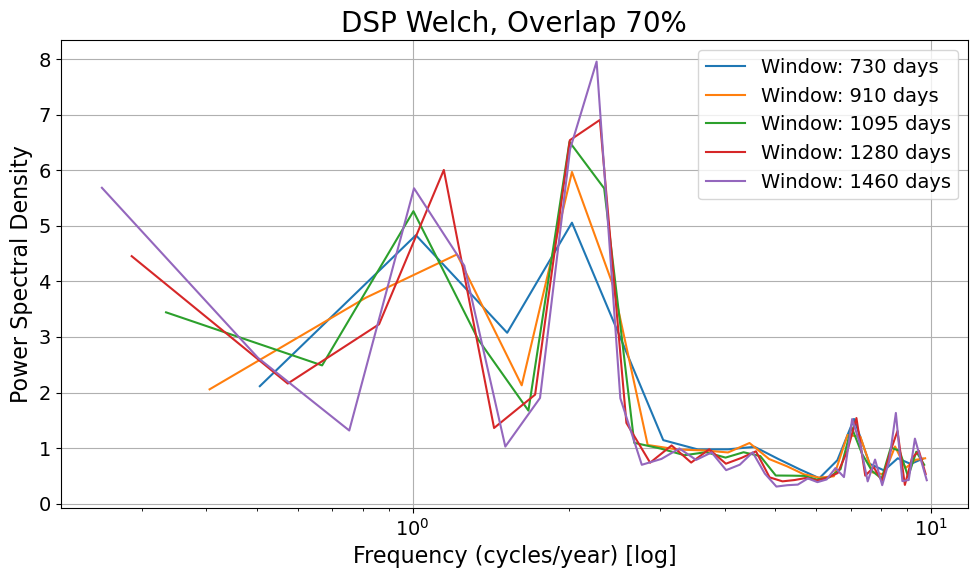


===== Overlap Analysis = 80% =====
 WL = 730 days — Dominant periods ≈ [np.float64(0.986), np.float64(0.493)] years or, [360. 180.]  days
 WL = 910 days — Dominant periods ≈ [np.float64(0.822), np.float64(0.493)] years or, [300. 180.]  days
 WL = 1095 days — Dominant periods ≈ [np.float64(0.997), np.float64(0.499)] years or, [364. 182.]  days
 WL = 1280 days — Dominant periods ≈ [np.float64(0.871), np.float64(0.436)] years or, [318. 159.]  days
 WL = 1460 days — Dominant periods ≈ [np.float64(0.995), np.float64(0.442)] years or, [363.         161.33333333]  days
✔ Figure sauvegardée : figures_welch\PSD_overlap_80pct_VH_DSC.png


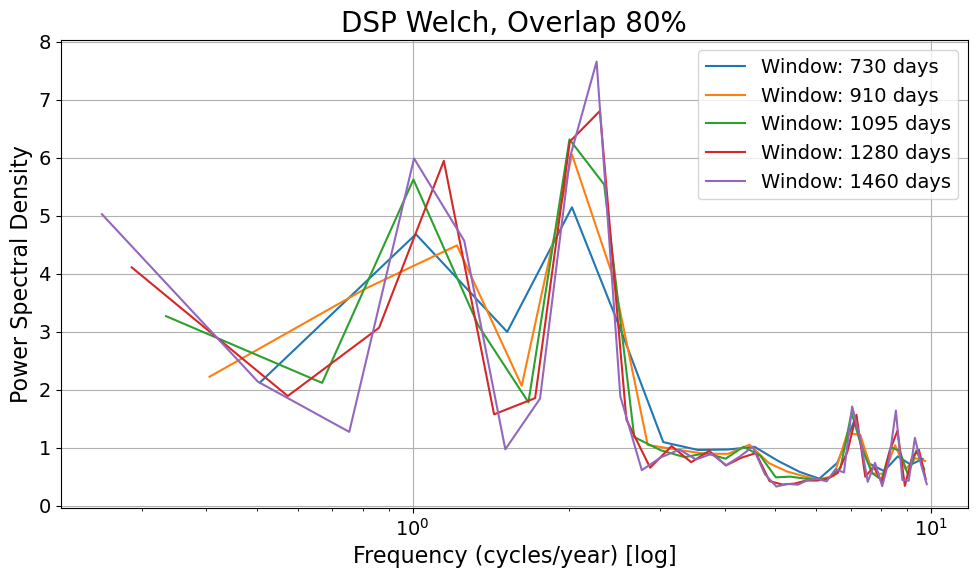


===== Overlap Analysis = 90% =====
 WL = 730 days — Dominant periods ≈ [np.float64(0.986), np.float64(0.493)] years or, [360. 180.]  days
 WL = 910 days — Dominant periods ≈ [np.float64(0.822), np.float64(0.493)] years or, [300. 180.]  days
 WL = 1095 days — Dominant periods ≈ [np.float64(0.997), np.float64(0.499)] years or, [364. 182.]  days
 WL = 1280 days — Dominant periods ≈ [np.float64(0.871), np.float64(0.436)] years or, [318. 159.]  days
 WL = 1460 days — Dominant periods ≈ [np.float64(0.995), np.float64(0.442)] years or, [363.         161.33333333]  days
✔ Figure sauvegardée : figures_welch\PSD_overlap_90pct_VH_DSC.png


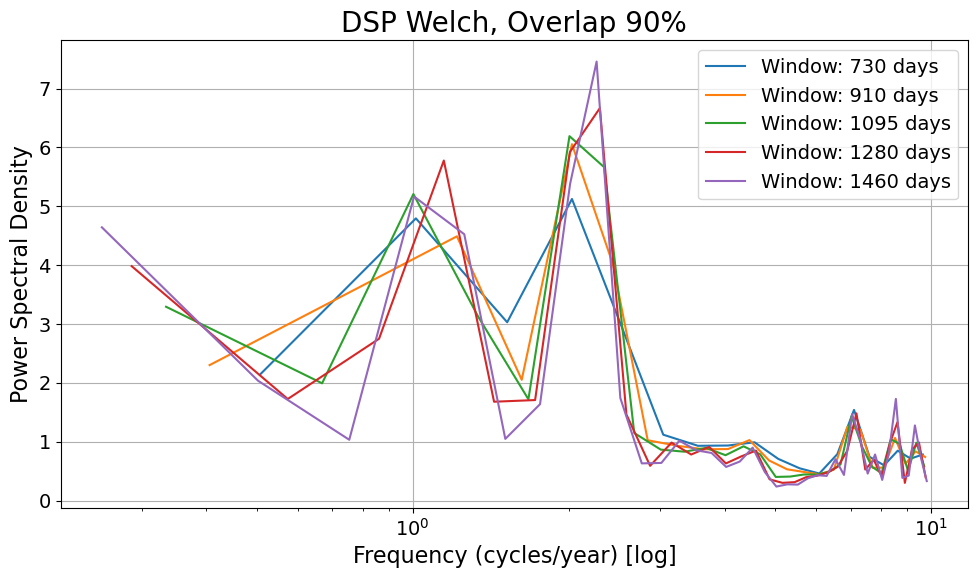

In [63]:
psd_welch_annee(value_allROI, "VH_DSC", window_lengths=[730, 910, 1095, 1280, 1460], overlap_ratios=[0.70,0.80,0.90], n_peaks=2, outdir="figures_welch", prefix="PSD", show=True)